In [ ]:
!pip install torch-scatter torch-geometric openpyxl

import pandas as pd
import torch
from torch_geometric.data import Data
from torch_scatter import scatter_mean
import json

# Load both datasets
edges_df = pd.read_excel("Data title.xlsx")   # your edge + graph info
titles_df = pd.read_excel("Dataset cap1.xlsx")        # optional node info (if needed)

# Parse edge PROPERTIES
edges_df['PROPERTIES'] = edges_df['PROPERTIES'].apply(lambda x: [float(i) for i in str(x).split(',')])

# Build node ID map
all_nodes = pd.concat([edges_df['SOURCE_SUBREDDIT'], edges_df['TARGET_SUBREDDIT']]).unique()
node2id = {name: i for i, name in enumerate(all_nodes)}

edges_df['src'] = edges_df['SOURCE_SUBREDDIT'].map(node2id)
edges_df['tgt'] = edges_df['TARGET_SUBREDDIT'].map(node2id)

# Build edge list, edge features, and labels
edge_index = torch.tensor([edges_df['src'].values, edges_df['tgt'].values], dtype=torch.long)
edge_attr = torch.tensor(edges_df['PROPERTIES'].tolist(), dtype=torch.float)
y = torch.tensor((edges_df['LINK_SENTIMENT'] > 0).astype(int).values, dtype=torch.long)

# Node features (optional: from titles_df if useful)
# For now, use edge feature mean per node
num_nodes = len(node2id)
node_feat = scatter_mean(edge_attr, torch.tensor(edges_df['src'].values), dim=0, dim_size=num_nodes)

# Sort by time and split
edges_df = edges_df.sort_values('TIMESTAMP')
n = len(edges_df)
train_idx = list(range(0, int(0.7 * n)))
val_idx   = list(range(int(0.7 * n), int(0.85 * n)))
test_idx  = list(range(int(0.85 * n), n))

# Create graph object
data = Data(
    x=node_feat,
    edge_index=edge_index,
    edge_attr=edge_attr,
    y=y
)
data.train_idx = torch.tensor(train_idx)
data.val_idx = torch.tensor(val_idx)
data.test_idx = torch.tensor(test_idx)

# Save outputs
torch.save(data, "dataset_processed.pt")
with open("node2id.json", "w") as f:
    # Manually build a JSON-compatible dictionary
    json_compatible_node2id = {str(k): v for k, v in node2id.items()}
    json.dump(json_compatible_node2id, f)

print("✅ Done. Files generated:")
print("→ dataset_processed.pt")
print("→ node2id.json")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=04aa6a74a664bf86d135893ecc6109e64cd9c9d62687a63049ed6e3133c2257b
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter


/tmp/ipython-input-2286252484.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([edges_df['src'].values, edges_df['tgt'].values], dtype=torch.long)


✅ Done. Files generated:
→ dataset_processed.pt
→ node2id.json


In [ ]:


!pip install torch-geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv

# ---- Step 1. Load Processed Data ----
data = torch.load("dataset_processed.pt", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# ---- Step 2. Model Definition ----

class EdgeClassificationModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.gat = GATConv(hidden_channels, hidden_channels)
        # Add a layer to combine node embeddings for edge prediction
        self.lin = nn.Linear(hidden_channels * 2, out_channels) # Multiply by 2 for concatenating source and target node embeddings

    def forward(self, x, edge_index):
        # Pass through graph layers to get node embeddings
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.gat(x, edge_index)
        x = F.relu(x)

        # Get embeddings for source and target nodes of each edge
        source_node_embeddings = x[edge_index[0]]
        target_node_embeddings = x[edge_index[1]]

        # Concatenate source and target node embeddings
        edge_embeddings = torch.cat([source_node_embeddings, target_node_embeddings], dim=1)

        # Pass through a linear layer for edge classification
        return self.lin(edge_embeddings)


model = EdgeClassificationModel(data.x.size(1), 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Use the edge indices for training, validation, and testing
train_edge_index = data.edge_index[:, data.train_idx]
val_edge_index = data.edge_index[:, data.val_idx]
test_edge_index = data.edge_index[:, data.test_idx]

train_labels = data.y[data.train_idx]
val_labels = data.y[data.val_idx]
test_labels = data.y[data.test_idx]


# ---- Step 3. Training Loop ----
for epoch in range(1, 21):
    model.train()
    optimizer.zero_grad()
    # Pass the relevant edge indices to the model
    out = model(data.x, data.edge_index) # Model outputs predictions for all edges
    loss = criterion(out[data.train_idx], train_labels) # Calculate loss only for training edges
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index) # Model outputs predictions for all edges
        pred = val_out[data.val_idx].argmax(dim=1) # Get predictions for validation edges
        acc = (pred == val_labels).sum().item() / len(val_labels)
    print(f'Epoch {epoch:02d} | Loss {loss.item():.4f} | Val Acc {acc:.4f}')


# ---- Step 4. Save Trained Model ----
torch.save(model.state_dict(), "model.pt")

# ---- Step 5. Save Node Embeddings ----
# To get node embeddings after training, we can run the initial part of the model
# which produces node representations before the edge prediction layer.
class NodeEmbeddingModel(nn.Module):
    def __init__(self, edge_model):
        super().__init__()
        self.sage1 = edge_model.sage1
        self.gat = edge_model.gat

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.gat(x, edge_index)
        x = F.relu(x)
        return x

node_embedding_model = NodeEmbeddingModel(model).to(device)
node_embedding_model.eval()
with torch.no_grad():
    embeddings = node_embedding_model(data.x, data.edge_index)
torch.save(embeddings.cpu(), "node_embeddings.pt")


print("✅ Training complete. Files saved: model.pt, node_embeddings.pt")

Epoch 01 | Loss 1.3219 | Val Acc 0.8112
Epoch 02 | Loss 0.5295 | Val Acc 0.8899
Epoch 03 | Loss 0.3708 | Val Acc 0.8930
Epoch 04 | Loss 0.4156 | Val Acc 0.8930
Epoch 05 | Loss 0.4757 | Val Acc 0.8930
Epoch 06 | Loss 0.5170 | Val Acc 0.8930
Epoch 07 | Loss 0.5352 | Val Acc 0.8930
Epoch 08 | Loss 0.5335 | Val Acc 0.8930
Epoch 09 | Loss 0.5162 | Val Acc 0.8930
Epoch 10 | Loss 0.4882 | Val Acc 0.8930
Epoch 11 | Loss 0.4540 | Val Acc 0.8930
Epoch 12 | Loss 0.4187 | Val Acc 0.8930
Epoch 13 | Loss 0.3873 | Val Acc 0.8930
Epoch 14 | Loss 0.3655 | Val Acc 0.8929
Epoch 15 | Loss 0.3563 | Val Acc 0.8929
Epoch 16 | Loss 0.3589 | Val Acc 0.8929
Epoch 17 | Loss 0.3680 | Val Acc 0.8927
Epoch 18 | Loss 0.3766 | Val Acc 0.8927
Epoch 19 | Loss 0.3802 | Val Acc 0.8928
Epoch 20 | Loss 0.3778 | Val Acc 0.8929
✅ Training complete. Files saved: model.pt, node_embeddings.pt


Embeddings shape: torch.Size([54075, 64])
✅ Saved influencer_ranking.csv with combined metrics


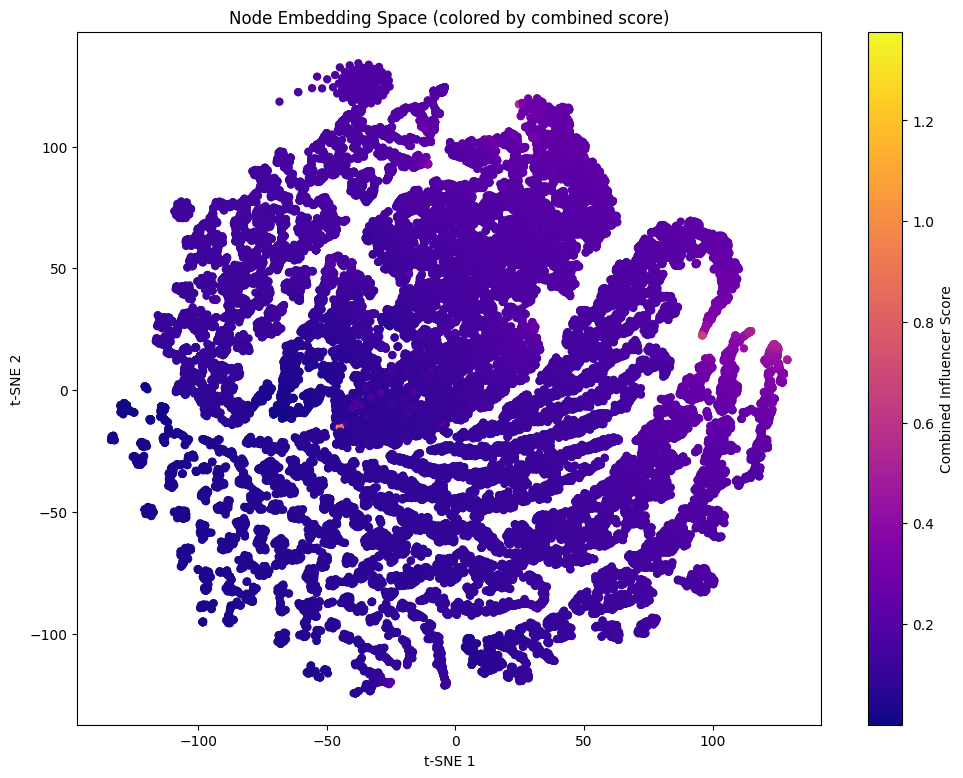

In [ ]:


!pip install pandas scikit-learn matplotlib networkx

import torch
import pandas as pd
import json
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx

# ---- Step 1. Load embeddings and node mapping ----
embeddings = torch.load("node_embeddings.pt")
with open("node2id.json", "r") as f:
    node2id = json.load(f)

id2node = {v: k for k, v in node2id.items()}
num_nodes = embeddings.shape[0]

print("Embeddings shape:", embeddings.shape)

# ---- Step 2. Load Graph Structure (edge_index) ----
# We need the original graph to compute PageRank
data = torch.load("dataset_processed.pt", weights_only=False)
edge_index = data.edge_index.cpu().numpy()

# Build directed NetworkX graph
G = nx.DiGraph()
G.add_nodes_from(range(num_nodes))
edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)

# ---- Step 3. Compute Embedding Norm Score ----
scores_emb = embeddings.norm(dim=1).cpu().numpy()

# ---- Step 4. Compute PageRank & Betweenness ----
pagerank_scores = nx.pagerank(G)
betweenness_scores = nx.betweenness_centrality(G, k=min(500, num_nodes))  # sample if large

# Convert to arrays aligned with node indices
scores_pr = np.array([pagerank_scores[i] for i in range(num_nodes)])
scores_bt = np.array([betweenness_scores[i] for i in range(num_nodes)])

# ---- Step 5. Combine Scores ----
# Simple weighted sum of normalized scores
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-9)

combined_score = normalize(scores_emb) + normalize(scores_pr) + normalize(scores_bt)

# ---- Step 6. Rank nodes by combined score ----
ranked_indices = np.argsort(combined_score)[::-1]
ranked_nodes = [(id2node[i], combined_score[i], scores_emb[i], scores_pr[i], scores_bt[i]) for i in ranked_indices]

# ---- Step 7. Save ranking to CSV ----
df_rank = pd.DataFrame(ranked_nodes, columns=["Node", "CombinedScore", "EmbeddingNorm", "PageRank", "Betweenness"])
df_rank.to_csv("influencer_ranking.csv", index=False)
print("✅ Saved influencer_ranking.csv with combined metrics")

# ---- Step 8. Visualize Embedding Space ----
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings.cpu().numpy())

plt.figure(figsize=(12,9))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=combined_score, cmap='plasma', s=25)
plt.colorbar(label="Combined Influencer Score")
plt.title("Node Embedding Space (colored by combined score)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Top 20 influencers:
              Node  CombinedScore  EmbeddingNorm  PageRank  Betweenness
0             iama       1.376095      14.023617  0.013626     0.010805
1            funny       1.210967      12.298063  0.007145     0.022630
2           gaming       1.198384      12.725624  0.004533     0.029092
3   subredditdrama       1.153428      14.475554  0.001202     0.035972
4           bestof       1.137432      15.005697  0.000677     0.036664
5    todayilearned       1.038215      13.237741  0.004785     0.022411
6             pics       1.030396      12.375990  0.008018     0.013640
7        fabriksny       1.000000     148.343960  0.000005     0.000000
8       the_donald       0.980343      14.867111  0.004486     0.020688
9        askreddit       0.941986      11.857753  0.011929     0.000000
10          videos       0.841008      12.809531  0.005835     0.012462
11     christients       0.656371      98.098015  0.000005     0.000000
12   nfscirclejerk       0.631862      94.51

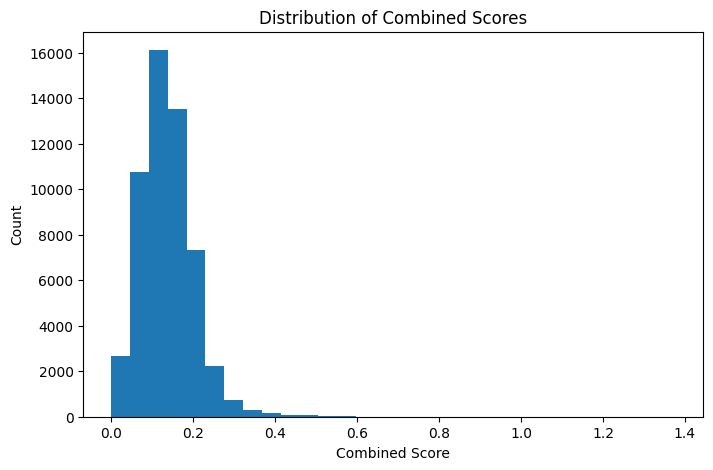


Top influencers matching 'league':
                      Node  CombinedScore  EmbeddingNorm  PageRank  \
248        leagueoflegends       0.407845      13.158463  0.002510   
605            texasleague       0.335036      51.111977  0.000005   
824   leagueofappreciation       0.310608      47.540028  0.000005   
982   leaguefactionbattles       0.297551      45.630875  0.000005   
2877           theleaguefx       0.240450      37.277233  0.000006   

      Betweenness  
248      0.005443  
605      0.000000  
824      0.000000  
982      0.000000  
2877     0.000000  


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# ---- Load influencer ranking file ----
df = pd.read_csv("influencer_ranking.csv")

# ---- Recommendation helper ----
def recommend_influencers(keyword, top_k=10):
    """
    Return top_k influencers whose Node name contains keyword (case-insensitive)
    """
    return df[df["Node"].str.contains(keyword, case=False)].head(top_k)

# ---- Show top influencers ----
print("Top 20 influencers:")
print(df.head(20))

# ---- Plot combined score distribution inline ----
plt.figure(figsize=(8,5))
plt.hist(df["CombinedScore"], bins=30)
plt.xlabel("Combined Score")
plt.ylabel("Count")
plt.title("Distribution of Combined Scores")
plt.show()

# ---- Example recommendation ----
keyword = "league"  # change this to any keyword you want
print(f"\nTop influencers matching '{keyword}':")
print(recommend_influencers(keyword, 5))
